alexnet으로 gradcam을 보며 dataset 테스트.  
dataset에 따라 처리 다르게 해야함  
현재는 face_cropped data에 적용되어있음

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import time
import copy


In [15]:
class ResizeWithPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        
        scale = self.target_size / max(w, h)
        
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        # 비율 유지하며 리사이즈
        resized_img = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 검은색 캔버스 생성
        canvas = Image.new("RGB", (self.target_size, self.target_size), (0, 0, 0))
        
        # 캔버스 중앙에 리사이즈된 이미지 배치
        pad_x = (self.target_size - new_w) // 2
        pad_y = (self.target_size - new_h) // 2
        
        canvas.paste(resized_img, (pad_x, pad_y))
        
        return canvas

In [16]:
class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.resizer = ResizeWithPad(224)
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 디스크에서 이미지 경로로 이미지 로드 (PIL)
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.resizer(image)
        

        return image

In [17]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
class RAMDataset(Dataset):
    def __init__(self, images_uint8, labels, transform=None):
        self.images = images_uint8 # (N, C, H, W) uint8 tensor
        self.labels = labels
        self.transform = transform
        # 정규화용 transform (여기서 float변환 및 정규화 수행)
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        # 1. uint8 텐서 가져오기
        img = self.images[idx] 
        
        # 2. float32로 변환 및 0~1 스케일링 (매우 빠름)
        img = img.float() / 255.0
        
        # 3. 정규화 적용
        img = self.normalize(img)
        
        # 4. 추가 증강(Augmentation)이 있다면 여기서 적용 가능
        if self.transform:
            img = self.transform(img)
            
        label = self.labels[idx]
        return img, label

def load_images_to_ram_uint8(paths):
    """
    이미지를 읽어서 리사이즈 후 uint8 텐서로 변환하여 리스트에 저장
    """
    to_tensor = transforms.PILToTensor() # uint8 유지 (0-255)
    resizer = ResizeWithPad(224)
    
    tensor_list = []
    print(f"Loading {len(paths)} images to RAM (uint8 mode)...")
    
    for path in tqdm(paths):
        try:
            img = Image.open(path).convert('RGB')
            img = resizer(img)
            tensor = to_tensor(img) # (3, 224, 224) uint8 Tensor
            tensor_list.append(tensor)
        except Exception as e:
            print(f"Error loading {path}: {e}")

            
    return torch.stack(tensor_list) # (N, 3, 224, 224) uint8 Tensor

In [18]:
class AlexNetLike(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetLike, self).__init__()
        self.features = nn.Sequential(
            # Conv 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), # 224 -> 55
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 55 -> 27
            
            # Conv 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 27 -> 27
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 -> 13
            
            # Conv 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Conv 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Conv 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13 -> 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes) # num_classes=1
        )
    def forward(self, x):
        x = self.features(x); x = self.avgpool(x)
        x = torch.flatten(x, 1); x = self.classifier(x)
        return x

In [19]:
def get_model(model_name, device):

    model = None
    num_classes = 1 # 이진 분류 (Real/Fake)
    
    print(f"Loading {model_name} architecture (FROM SCRATCH)...")

    if model_name.lower() == 'alexnet': 
        # 직접 짠 AlexNet (Conv 5, FC 3)
        model =  AlexNetLike(num_classes=num_classes)
    
    elif model_name.lower() == 'vgg16':
        # VGG16
        model = models.vgg16(weights=None, num_classes=num_classes)
    
    elif model_name.lower() == 'googlenet':
        # GoogLeNet
        model = models.googlenet(weights=None, num_classes=num_classes, aux_logits=False)
    
    elif model_name.lower() == 'resnet50':
        # ResNet50
        model = models.resnet50(weights=None, num_classes=num_classes)
    
    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose from 'alexnet, 'vgg16', 'googlenet', 'resnet50'")
        
    return model.to(device)


In [20]:
# 학습
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience):
    print("=== 학습 시작 ===")
    
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # --- 훈련 ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # tqdm으로 진행 상황 표시
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            # 정확도 계산
            preds = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            
            train_pbar.set_postfix({'loss': loss.item()})
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # --- 검증 ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * images.size(0)
                
                preds = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - {elapsed_time:.0f}s - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # --- Early Stopping 및 Best Model 저장 ---
        if epoch_val_loss < best_val_loss:
            print(f"  Validation loss decreased ({best_val_loss:.4f} --> {epoch_val_loss:.4f}). Saving model...")
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights, MODEL_SAVE_PATH)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
            
    print("=== 학습 완료 ===")
    model.load_state_dict(best_model_weights)
    return model

In [21]:
# 평가
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    print("\n=== 테스트셋 평가 시작 ===")
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="[Test]", leave=False)
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            total_test += labels.size(0)
            correct_test += (preds == labels).sum().item()
            
    test_loss = running_test_loss / len(test_loader.dataset)
    test_acc = correct_test / total_test
    
    print(f"===== 최종 테스트 결과 =====")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc * 100:.2f}%")

In [22]:
IMG_SIZE = 224
EPOCHS = 30
BATCH_SIZE = 64
NUM_SAMPLES = 0
LEARNING_RATE = 1e-4
PATIENCE = 5  

In [23]:
# 메인 실행
start_time = time.time()

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 데이터 경로 및 라벨 수집
Fake_PATH = "D:/workspace/python/experiments/dataset/univ_ML_basic/deepfake/cropped/face_fake"
Real_PATH = "D:/workspace/python/experiments/dataset/univ_ML_basic/deepfake/cropped/face_real"
MODEL_SAVE_PATH = "D:/workspace/python/experiments//deepfake_baseline_model.pth"
print("이미지 경로 수집 중...")
face_real_dir = os.path.join(Real_PATH)
face_fake_dir = os.path.join(Fake_PATH)

real_paths = glob.glob(os.path.join(face_real_dir, "*.*"))
fake_paths = glob.glob(os.path.join(face_fake_dir, "*.*"))

all_paths = real_paths + fake_paths
NUM_SAMPLES = len(all_paths)
all_labels = [0] * len(real_paths) + [1] * len(fake_paths)

print(f"총 {len(all_labels)}개 이미지 경로 발견.")

# 10000개 샘플링
target_paths = all_paths
target_labels = all_labels
    
# 전체를 쓰더라도 학습을 위해 섞어줍니다.
combined = list(zip(target_paths, target_labels))
np.random.shuffle(combined)
target_paths[:], target_labels[:] = zip(*combined)

Using device: cuda
이미지 경로 수집 중...
총 68479개 이미지 경로 발견.


In [24]:
print("데이터를 7:2:1 비율로 분할합니다...")
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    target_paths, target_labels, test_size=0.3, random_state=42, stratify=target_labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=(1/3), random_state=42, stratify=temp_labels
)
print(f"분할 완료: Train {len(train_paths)}개, Validation {len(val_paths)}개, Test {len(test_paths)}개")


데이터를 7:2:1 비율로 분할합니다...
분할 완료: Train 47935개, Validation 13696개, Test 6848개


In [25]:
# 데이터 전처리 및 RAM에 로드 
print("데이터 전처리를 시작합니다 (모든 데이터를 RAM에 로드)...")

# 모든 데이터를 RAM으로 로드
X_train = load_images_to_ram_uint8(train_paths)
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

X_val = load_images_to_ram_uint8(val_paths)
y_val = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

X_test = load_images_to_ram_uint8(test_paths)
y_test = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

print("모든 데이터를 RAM에 로드 완료.")

# RAM 기반의 TensorDataset과 DataLoader 생성 
train_dataset = RAMDataset(X_train, y_train, transform=None) 
val_dataset = RAMDataset(X_val, y_val, transform=None)
test_dataset = RAMDataset(X_test, y_test, transform=None)

# RAM에서 읽으므로 num_workers=0, pin_memory=False (이미 RAM에 있음)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("데이터 로더 생성 완료.")

데이터 전처리를 시작합니다 (모든 데이터를 RAM에 로드)...
Loading 47935 images to RAM (uint8 mode)...


100%|██████████| 47935/47935 [07:29<00:00, 106.60it/s] 


Loading 13696 images to RAM (uint8 mode)...


100%|██████████| 13696/13696 [01:59<00:00, 114.41it/s]


Loading 6848 images to RAM (uint8 mode)...


100%|██████████| 6848/6848 [01:16<00:00, 89.51it/s] 


모든 데이터를 RAM에 로드 완료.
데이터 로더 생성 완료.


In [26]:
start_time = time.time()
# 8. 모델, 손실함수, 옵티마이저 정의
model = get_model('alexnet', device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 9. 학습 및 평가
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS, PATIENCE)
evaluate_model(model, test_loader, criterion, device)

print(f"총 실행 시간: {(time.time() - start_time) / 60:.2f} 분")

Loading alexnet architecture (FROM SCRATCH)...
=== 학습 시작 ===


Epoch 1/30 - 50s - Train Loss: 0.6303, Train Acc: 0.6378 - Val Loss: 0.6592, Val Acc: 0.6078
  Validation loss decreased (inf --> 0.6592). Saving model...


Epoch 2/30 - 50s - Train Loss: 0.5370, Train Acc: 0.7220 - Val Loss: 0.6015, Val Acc: 0.6766
  Validation loss decreased (0.6592 --> 0.6015). Saving model...


Epoch 3/30 - 50s - Train Loss: 0.4827, Train Acc: 0.7582 - Val Loss: 0.5398, Val Acc: 0.7129
  Validation loss decreased (0.6015 --> 0.5398). Saving model...


Epoch 4/30 - 50s - Train Loss: 0.4406, Train Acc: 0.7835 - Val Loss: 0.4838, Val Acc: 0.7519
  Validation loss decreased (0.5398 --> 0.4838). Saving model...


Epoch 5/30 - 50s - Train Loss: 0.4070, Train Acc: 0.8046 - Val Loss: 0.4770, Val Acc: 0.7586
  Validation loss decreased (0.4838 --> 0.4770). Saving model...


Epoch 6/30 - 50s - Train Loss: 0.3776, Train Acc: 0.8193 - Val Loss: 0.4541, Val Acc: 0.7713
  Validation loss decreased (0.4770 --> 0.4541). Saving model...


Epoch 7/30 - 51s - Train Loss: 0.3532, Train Acc: 0.8309 - Val Loss: 0.4103, Val Acc: 0.8064
  Validation loss decreased (0.4541 --> 0.4103). Saving model...


Epoch 8/30 - 51s - Train Loss: 0.3246, Train Acc: 0.8479 - Val Loss: 0.4084, Val Acc: 0.7950
  Validation loss decreased (0.4103 --> 0.4084). Saving model...


Epoch 9/30 - 51s - Train Loss: 0.3082, Train Acc: 0.8573 - Val Loss: 0.4138, Val Acc: 0.8020
  Validation loss did not improve. Patience: 1/5


Epoch 10/30 - 51s - Train Loss: 0.2875, Train Acc: 0.8674 - Val Loss: 0.3855, Val Acc: 0.8192
  Validation loss decreased (0.4084 --> 0.3855). Saving model...


Epoch 11/30 - 51s - Train Loss: 0.2671, Train Acc: 0.8788 - Val Loss: 0.4259, Val Acc: 0.7942
  Validation loss did not improve. Patience: 1/5


Epoch 12/30 - 51s - Train Loss: 0.2515, Train Acc: 0.8869 - Val Loss: 0.4464, Val Acc: 0.7988
  Validation loss did not improve. Patience: 2/5


Epoch 13/30 - 51s - Train Loss: 0.2336, Train Acc: 0.8939 - Val Loss: 0.3825, Val Acc: 0.8124
  Validation loss decreased (0.3855 --> 0.3825). Saving model...


Epoch 14/30 - 51s - Train Loss: 0.2178, Train Acc: 0.9030 - Val Loss: 0.3723, Val Acc: 0.8253
  Validation loss decreased (0.3825 --> 0.3723). Saving model...


Epoch 15/30 - 51s - Train Loss: 0.2039, Train Acc: 0.9086 - Val Loss: 0.4310, Val Acc: 0.8069
  Validation loss did not improve. Patience: 1/5


Epoch 16/30 - 51s - Train Loss: 0.1867, Train Acc: 0.9166 - Val Loss: 0.4261, Val Acc: 0.8173
  Validation loss did not improve. Patience: 2/5


Epoch 17/30 - 51s - Train Loss: 0.1802, Train Acc: 0.9212 - Val Loss: 0.4178, Val Acc: 0.8259
  Validation loss did not improve. Patience: 3/5


Epoch 18/30 - 51s - Train Loss: 0.1639, Train Acc: 0.9286 - Val Loss: 0.3934, Val Acc: 0.8367
  Validation loss did not improve. Patience: 4/5


Epoch 19/30 - 51s - Train Loss: 0.1548, Train Acc: 0.9325 - Val Loss: 0.4972, Val Acc: 0.8159
  Validation loss did not improve. Patience: 5/5
Early stopping triggered after 19 epochs.
=== 학습 완료 ===

=== 테스트셋 평가 시작 ===


===== 최종 테스트 결과 =====
  Test Loss: 0.3570
  Test Accuracy: 84.10%
총 실행 시간: 16.09 분


In [27]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob
import random
import cv2

class AlexNetLike(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetLike, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384), nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )
        
        # Grad-CAM을 위한 변수
        self.gradients = None
    
    # Hook for gradients
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        # features의 마지막 레이어 출력(Activation)을 잡아야 함
        # 하지만 Sequential이라 중간에 hook 걸기가 까다로우므로,
        # features를 통과시킨 직후의 값을 이용함
        x = self.features(x)
        
        # 학습/추론 시에는 영향 없음, Grad-CAM 호출 시에만 hook 등록됨
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
            
        self.last_conv_output = x # Activation 저장
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    # Grad-CAM 생성 메서드
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.last_conv_output

def get_model2(model_name, device):
    # 편의상 AlexNet만 구현 (필요시 확장)
    if model_name.lower() == 'alexnet_like': 
        model = AlexNetLike(num_classes=1)
    else:
        raise ValueError("이 스크립트는 현재 AlexNetLike 전용입니다.")
    return model.to(device)

모델 로드 성공!

=== 랜덤 10개 샘플 Grad-CAM 분석 ===
[1/10] Sample_3713
GT: Real | Pred: Real (0.00)


C:\Users\박동욱\AppData\Local\Temp\ipykernel_22796\3462825061.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_locatio

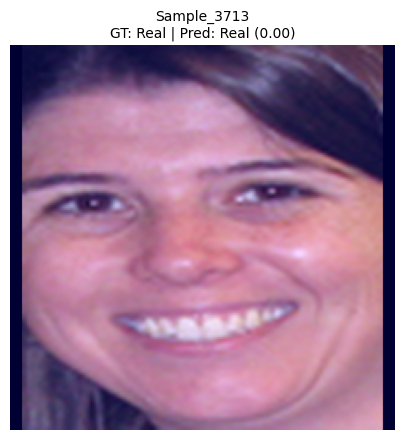

[2/10] Sample_2728
GT: Fake | Pred: Fake (0.97)


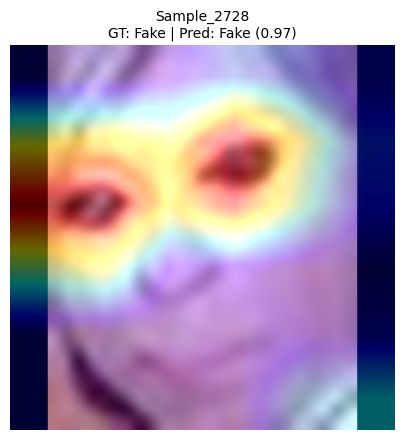

[3/10] Sample_2801
GT: Real | Pred: Real (0.34)


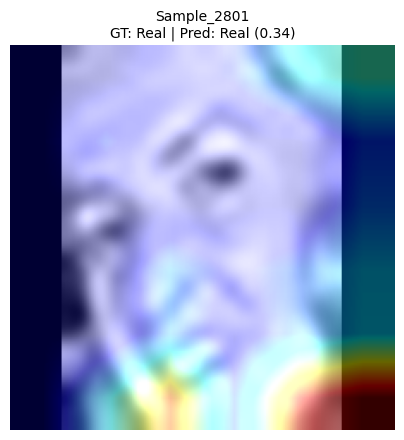

[4/10] Sample_5214
GT: Fake | Pred: Fake (0.97)


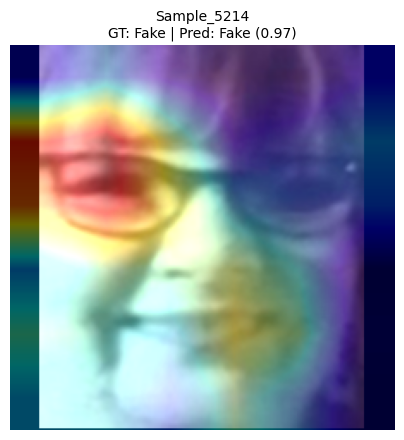

[5/10] Sample_3998
GT: Real | Pred: Real (0.04)


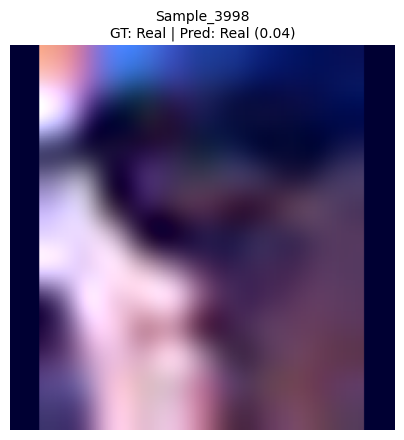

[6/10] Sample_473
GT: Fake | Pred: Fake (1.00)


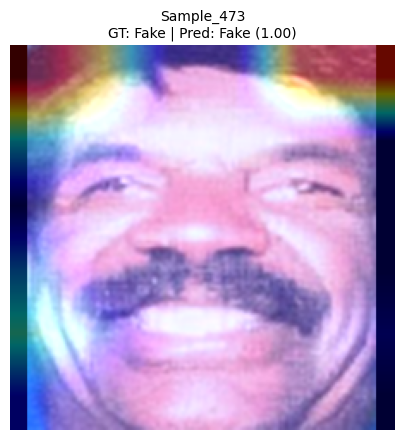

[7/10] Sample_5579
GT: Real | Pred: Fake (0.75)


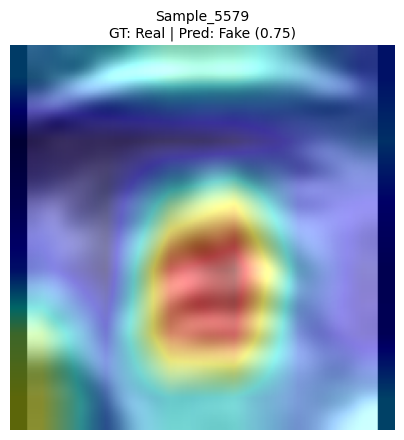

[8/10] Sample_4993
GT: Fake | Pred: Fake (1.00)


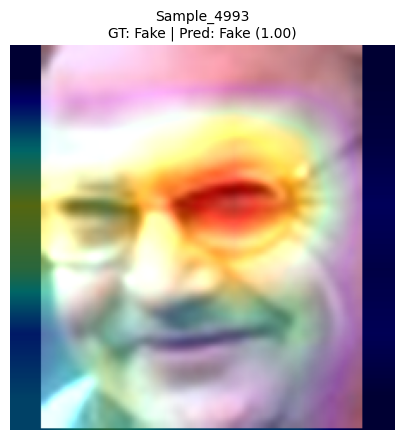

[9/10] Sample_1203
GT: Fake | Pred: Fake (1.00)


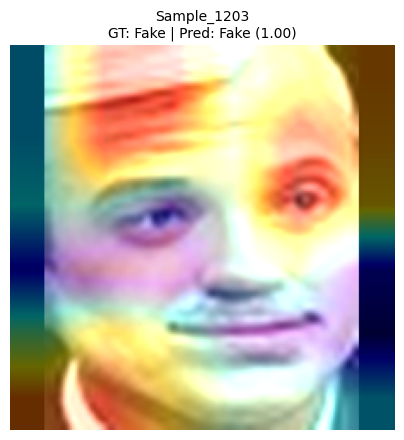

[10/10] Sample_2898
GT: Real | Pred: Real (0.37)


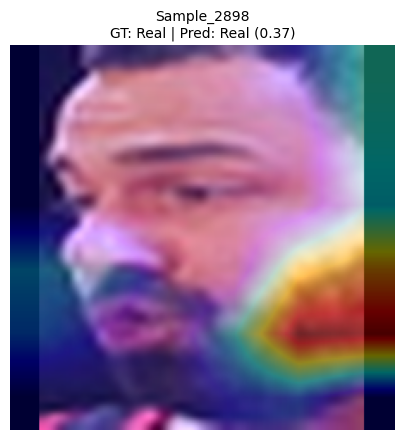

In [28]:
# --- 4. Grad-CAM 핵심 로직 ---
def generate_gradcam(model, image_tensor, device):
    # 1. 모델을 eval 모드로 전환 (Dropout 등 비활성화)
    # 하지만 Gradients 계산을 위해 requires_grad는 유지해야 함
    model.eval()
    
    # 2. 이미지 GPU로 이동 및 배치 차원 추가
    img = image_tensor.unsqueeze(0).to(device)
    img.requires_grad = True
    
    # 3. 순전파 (Forward)
    pred = model(img)
    
    # 4. 역전파 (Backward) - 타겟 클래스(0 or 1)에 대한 Gradient 계산
    # 이진 분류이므로 출력값 자체를 미분
    pred.backward()
    
    # 5. Gradients와 Activations 가져오기
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # 채널별 평균 Gradient
    activations = model.get_activations(img).detach()
    
    # 6. 가중치 적용 (Weighting)
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # 7. 채널 축으로 평균 (Heatmap 생성)
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    # 8. ReLU 적용 (양수값만 사용) 및 정규화
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    
    return heatmap.cpu().numpy()

# --- 5. 시각화 및 저장 ---
def show_gradcam(heatmap, img_uint8_tensor, title="Grad-CAM", save_path=None):
    """
    heatmap: Grad-CAM 결과 (2D numpy)
    img_uint8_tensor: RAM에 있던 원본 이미지 (C, H, W) uint8 텐서
    """
    # 1. 텐서(C,H,W)를 넘파이(H,W,C)로 변환
    original_img_np = img_uint8_tensor.permute(1, 2, 0).numpy()
    
    # 2. RGB -> BGR (OpenCV 호환용)
    original_img_cv = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2BGR)

    # 3. 히트맵 리사이징 (이미지 크기에 맞춤)
    heatmap = cv2.resize(heatmap, (original_img_np.shape[1], original_img_np.shape[0]))
    
    # 4. 히트맵 컬러맵 적용
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 5. 합성
    superimposed_img = heatmap * 0.4 + original_img_cv
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # 6. 저장 (옵션)
    if save_path:
        # 폴더가 없으면 생성
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(save_path, superimposed_img)
        # print(f"저장됨: {save_path}")
    
    # 7. 화면 출력 (BGR -> RGB)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(5, 5)) 
    plt.imshow(superimposed_img_rgb)
    plt.title(title, fontsize=10)
    plt.axis('off')
    plt.show()


# 2. 모델 로드
model = get_model2('alexnet_like', device)
try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print("모델 로드 성공!")
except Exception as e:
    print(f"모델 로드 실패: {e}")

# 4. 랜덤 10개 선택 및 Grad-CAM 실행
print("\n=== 랜덤 10개 샘플 Grad-CAM 분석 ===")

total_samples = len(test_dataset)
indices = random.sample(range(total_samples), 10)

for i, idx in enumerate(indices):
    # RAMDataset에서 입력용 텐서 가져옴
    img_tensor, label_tensor = test_dataset[idx]
    
    # 시각화 배경용: uint8 원본 텐서 가져옴
    bg_img_uint8 = X_test[idx] 
    
    # Grad-CAM 생성
    heatmap = generate_gradcam(model, img_tensor, device)
    
    # 예측값 확인
    with torch.no_grad():
        # eval 모드에서도 requires_grad는 꺼지지만, 
        # 안전하게 예측 시에는 torch.no_grad() 사용
        # (Grad-CAM 생성과 별도)
        output = model(img_tensor.unsqueeze(0).to(device))
        prob = torch.sigmoid(output).item()
        pred_label = 1 if prob > 0.5 else 0
        
    label_gt = int(label_tensor.item())
    label_str = "Fake" if label_gt == 1 else "Real"
    pred_str = "Fake" if pred_label == 1 else "Real"
    
    # 파일명이 없으므로 인덱스로 대체
    simple_title = f"Sample_{idx}\nGT: {label_str} | Pred: {pred_str} ({prob:.2f})"
    save_name = f"gradcam_results/gradcam_{i}_{label_str}_as_{pred_str}.jpg"
    
    print(f"[{i+1}/10] {simple_title}")
    show_gradcam(heatmap, bg_img_uint8, title=simple_title, save_path=save_name)

In [84]:
def check_gradcam(model, data_dir):
    Real_dir = os.path.join(data_dir, 'face_real')
    Fake_dir = os.path.join(data_dir, 'face_fake')

    Real_paths = glob.glob(os.path.join(Real_dir, "*"))
    Fake_paths = glob.glob(os.path.join(Fake_dir, "*"))

    n_samples = 5
    samples = random.sample(Real_paths, n_samples) + random.sample(Fake_paths, n_samples)
    labels = [0]*n_samples + [1]*n_samples # 0:Real, 1:Fake

    def aaa(samples, labels):
        preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        plt.figure(figsize=(15, 6))

        plt.suptitle(f"Bias Check", fontsize=16)

        print("Generating Grad-CAMs...")
        for i, (path, label_gt) in enumerate(zip(samples, labels)):
            # 이미지 로드
            try:
                pil_img = Image.open(path).convert('RGB')
            except: continue
            vis_img_np = np.array(pil_img)
            vis_img_cv = cv2.cvtColor(vis_img_np, cv2.COLOR_RGB2BGR) # OpenCV용

            # 모델 입력용
            input_tensor = preprocess(pil_img)
            
            # Grad-CAM & 예측
            heatmap = generate_gradcam(model, input_tensor, device)
            
            with torch.no_grad():
                out = model(input_tensor.unsqueeze(0).to(device))
                prob = torch.sigmoid(out).item()
                pred_label = 1 if prob > 0.5 else 0
            
            # 라벨링
            gt_str = "Fake" if label_gt == 1 else "Real"
            pred_str = "Fake" if pred_label == 1 else "Real"
            color = 'green' if label_gt == pred_label else 'red'
            
            # 시각화 합성
            heatmap = cv2.resize(heatmap, (vis_img_np.shape[1], vis_img_np.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            superimposed = heatmap * 0.4 + vis_img_cv
            superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
            superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

            # Plotting
            ax = plt.subplot(2, 5, i + 1)
            ax.imshow(superimposed)
            ax.set_title(f"GT:{gt_str}\nPred:{pred_str}\n({prob:.2f})", color=color, fontsize=10, fontweight='bold')
            ax.axis('off')
            
            # 파일명 표시 (길면 자름)
            fname = os.path.basename(path)
            if len(fname) > 15: fname = fname[:12] + "..."
            ax.text(0.5, -0.1, fname, size=8, ha="center", transform=ax.transAxes)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    
    def bbb(samples, labels):
        preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        plt.figure(figsize=(15, 6))

        plt.suptitle(f"Bias Check", fontsize=16)

        print("Generating Grad-CAMs...")
 
        for i, idx in enumerate(random.sample(range(len(test_dataset)), 10)):
            img, label_gt = test_dataset[idx]

            bg_img_uint8 = X_test[idx] 
            bg_img_uint8 = bg_img_uint8.permute(1, 2, 0).numpy()
            vis_img_cv = cv2.cvtColor(bg_img_uint8, cv2.COLOR_RGB2BGR) # OpenCV용

            # 모델 입력용
            input_tensor = img
            
            # Grad-CAM & 예측
            heatmap = generate_gradcam(model, input_tensor, device)
            
            with torch.no_grad():
                out = model(input_tensor.unsqueeze(0).to(device))
                prob = torch.sigmoid(out).item()
                pred_label = 1 if prob > 0.5 else 0
            
            # 라벨링
            label_gt = int(label_gt)
            gt_str = "Fake" if label_gt == 1 else "Real"
            pred_str = "Fake" if pred_label == 1 else "Real"
            color = 'green' if label_gt == pred_label else 'red'
            
            # 시각화 합성
            heatmap = cv2.resize(heatmap, (bg_img_uint8.shape[1], bg_img_uint8.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            superimposed = heatmap * 0.4 + vis_img_cv
            superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
            superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

            # Plotting
            ax = plt.subplot(2, 5, i + 1)
            ax.imshow(superimposed)
            ax.set_title(f"GT:{gt_str}\nPred:{pred_str}\n({prob:.2f})", color=color, fontsize=10, fontweight='bold')
            ax.axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # aaa(samples, labels)
    for idx in range(len(samples)):
        samples[idx] = samples[idx].replace("deepfake_60k_224px", "deepfake_60k_cropped_224px")
    # aaa(samples, labels)
    bbb(samples, labels)

Generating Grad-CAMs...


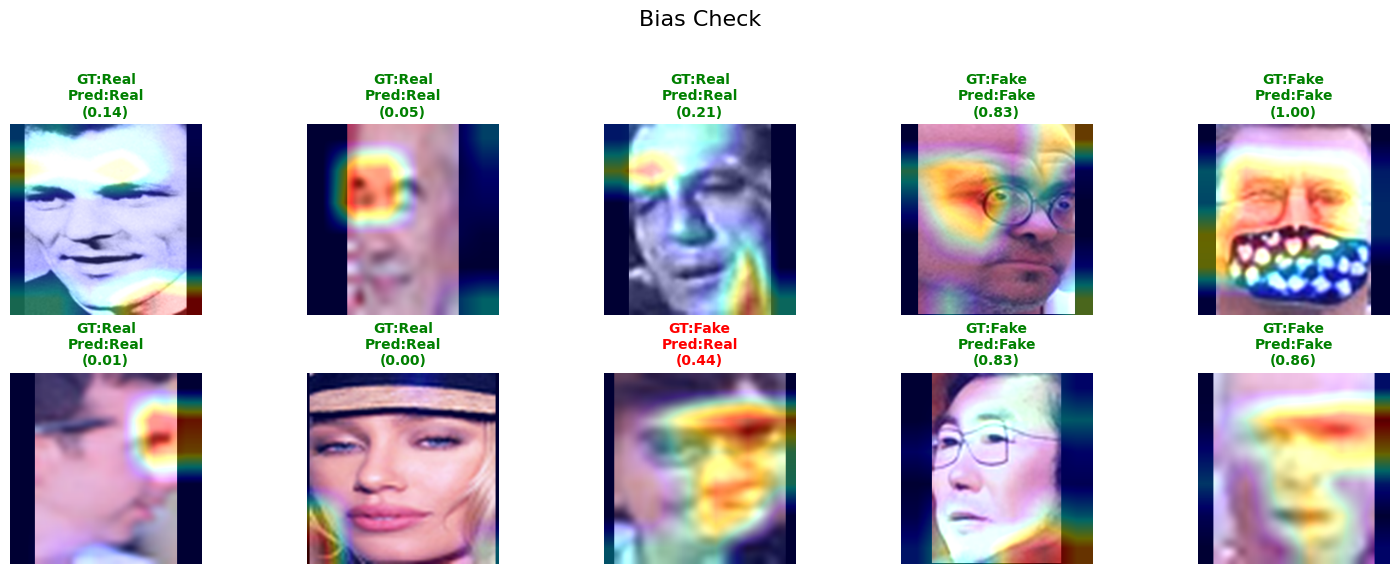

In [105]:
data_dir1 = "D:/workspace/python/experiments/dataset/deepfake_60k_224px"
data_dir0 = "D:/workspace/python/experiments/dataset/univ_ML_basic/deepfake/cropped"
data_dir2 = "D:/workspace/python/experiments/dataset/deepfake_60k_cropped_224px"
check_gradcam(model, data_dir1)
# check_gradcam(model, data_dir2)